# NLP Method: A Bridge from Federal Reserve Meeting Minutes to US Treasury Markets

# Project Objective

The objective of this project is to apply NLP methods on texts published by Federal Reserve Open Market Committee (FOMC) to quantify the communications in a systematic manner and find the relationship with Treasury
yield curve.

# Project Background

Financial Markets react to many kinds of information, such as GDP growth and unemployment rate. Traditionally, such quantitative factors can be easily included in trading or investment models, which provide market practitioners signals. However, along with the rise of Deep Learning, qualitative factors play more and more important roles in the investment world. One main category among qualitative factors is language analysis based on NLP. The wording in policies from government, especially regulators, such as Federal Reserve, is a perfect example.

# Target Problem

FOMC has eight regular meetings per year to determine U.S. monetary policy. Fed policy is based on current economy environment and the forecasted situations. Meanwhile, the policy itself also impacts future economy. The endogenous relationship between policy and reality makes their cause-effect relationship complicated. After each FOMC meeting, Fed publishes press conference minutes, statements, as well as scripts in text, as a result, the market regularly observes significant volatility around FOMC meetings. However, because the complexity of real-world financial markets, it is not straightforward to quantify the exact impact from FOMC meeting on markets.

# Table of Contents


1. [Data Overview](#data-o)
    <br>1.1 [Summary](#sum)
    <br>1.2 [Sections](#t-sect)
    <br>1.3 [Crop Sections](#crop)

2. [Data Pre-processing](#data-p)
    <br>2.1 [Tokenization](#stemlem)

3. [Topic Modelling](#topic-m)
    <br>3.1 [Non-negative matrix factorization](#nmf)
    <br>3.2 [Latent Dirichlet Allocation](#lda)
 
4. [Sentiment Analysis](#sent-a)
    <br>4.1 [Dictionary Approach](#dict)
    <br>4.2 [Sentiment Extraction](#sent-e)
    
5. [Modeling](#model)
    <br>5.1 [Treaaury Rates and Correlations](#rates)
    <br>5.1 [Baseline Model](#base)
    <br>5.2 [GloVe Embeddings](#glove)
    <br>5.3 [Elmo Embeddings](#elmo)
    <br>5.4 [Bert Embeddings](#bert)
    <br>5.5 [Deployment](#deploy)







In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -r drive/My\ Drive\/fednlp/requirements.txt
    file_path_prefix = './drive/My Drive/fednlp/'
    
    import torch
    device = torch.device("cuda:0")
else:
    file_path_prefix = '/Users/aaroncgw/Google Drive/fednlp/'

In [3]:
import re
import os,sys
import calendar
import datetime
from datetime import timedelta
from collections import Counter
import dill as pickle

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import CategorizedPlaintextCorpusReader
from wordcloud import WordCloud
import spacy
from spacy.lang.en import English
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer    

!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


Traceback (most recent call last):
  File "/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/urllib3/connection.py", line 160, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/urllib3/connectionpool.py", line 677, in urlopen
    chunked=chunked,
  File "/Users/aaronc

# <a name="data-o"></a> Data Overview
There are two components of the data. One is FOMC meeting minutes (text) and one is Treasury yield curve (numerical).

Meeting minutes data was web scrapped from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm.
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

## <a name="sum"></a>Minutes Summary

In [4]:
corpus_root = file_path_prefix + 'data/minutes'
data_m = CategorizedPlaintextCorpusReader(corpus_root, r'.*\.txt', cat_pattern=r'(\w+)/*')
data_fileids = data_m.fileids()

print('Total number of files: '+str(len(data_m.fileids())))
print('Number of paragraphs: '+str(len(data_m.paras())))
print('Number of sentences: '+str(len(data_m.sents())))
print('Number of words: '+str(len(data_m.words())))
print('\n'+'First file: '+ data_fileids[0])
print('Last file: '+ data_fileids[-1])

Total number of files: 131
Number of paragraphs: 16006
Number of sentences: 41414
Number of words: 1126076

First file: 2004/20040128.txt
Last file: 2020/20200610.txt


<AxesSubplot:xlabel='index', ylabel='Average number of words'>

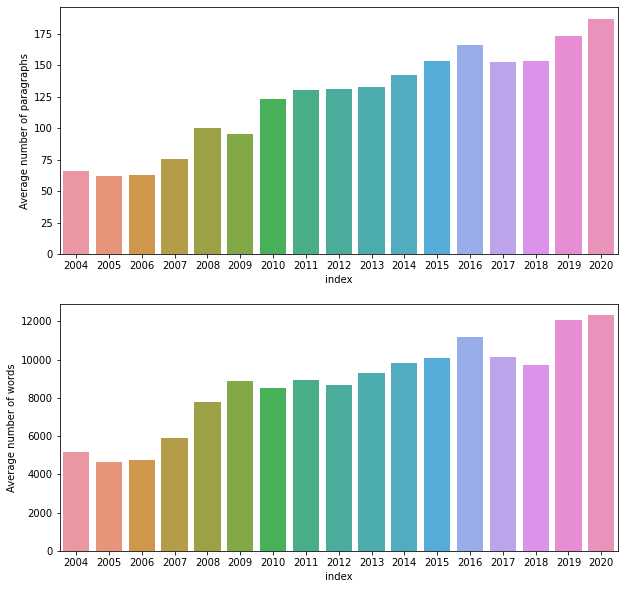

In [5]:
num_para_py = {}
num_word_py = {}

for y in range(2004,2021):
    files = data_m.fileids(str(y))
    files_size = len(files)
    num_para_py[y] = sum([len(data_m.paras(f))for f in files])/files_size
    num_word_py[y] = sum([len(data_m.words(f))for f in files])/files_size
        
para_words = pd.DataFrame([num_para_py,num_word_py],
                          index = ['Average number of paragraphs','Average number of words']).T

para_words = para_words.reset_index()

fig,ax = plt.subplots(2, 1, figsize=(10,10))
sns.barplot(x="index", y="Average number of paragraphs", data=para_words, ax=ax[0])
sns.barplot(x="index", y="Average number of words", data=para_words, ax=ax[1])

We can see an acceleration in the numbers of paragraphs and words overtime. Before the Global Finance Crisis (GFC 2008), FOMC minutes were 60 ~ 75 paragraphs, and between 4500 ~ 6000 words. After the crisis, monetary policy became more important to US economy. FOMC members need to address more aspects on policy consequences. Since last year, the minutes have been extended even longer because of increased complexicity from both the peaking of current economic cycle and massive internal trade conflicts.

## <a name="t-sect"></a> Sections
The minutes are split into 4 sections (see [Background on FOMC Meeting Minutes](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)) 

1. Introduction
2. Economic and financial information
3. Participants’ views on developments 
4. Policy decisions

The first set of introductory paragraphs contain a list of attendees and procedural items, which are not of use to our analysis and hence need to be removed. The next problem to tackle is knowing when to start the minutes from.

Text(0, 0.5, 'Word count')

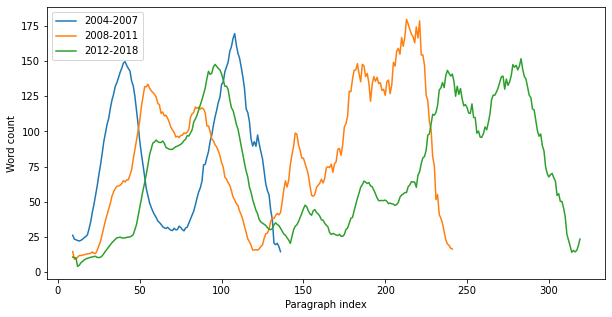

In [6]:
df_temp = pd.DataFrame()
df_year = pd.DataFrame()
for y in range(2004,2019):
    files = data_m.fileids(str(y))
    for f in files:
        word_para = [sum([len(s)for s in p]) for p in data_m.paras(f)]
        df_temp = pd.concat([df_temp,pd.Series(word_para,name=f)],axis=1)
    
    df_mean = df_temp.mean(axis=1)
    df_mean.name = y
    df_year= pd.concat([df_year,df_mean],axis=1)
    df_temp = df_temp.iloc[0:0]

window_size = 10

y1 = df_year.loc[:,[y for y in range(2004,2008)]].mean(axis=1).rolling(window_size).mean()
y2 = df_year.loc[:,[y for y in range(2009,2012)]].mean(axis=1).rolling(window_size).mean()
y3 = df_year.loc[:,[y for y in range(2012,2019)]].mean(axis=1).rolling(window_size).mean()

df_joint = pd.DataFrame([y1,y2,y3],index = ['2004-2007','2008-2011','2012-2018']).T


ax = df_joint.plot(figsize=(10,5))
ax.set_xlabel("Paragraph index")
ax.set_ylabel("Word count")

To see how the mintues are structured, we can plot a moving average of words per paragraph. The peaks and troughs of this moving average are indicative of new sections, where usually the start of the section includes a header or a very few words. 

For simplicity, we have identified three different types of structures that span from 2004-2007, 2008-2011 and 2012-2018 respectively. It is quite clear that the early minutes (2004-2007) began it's second section at paragraph 30-40, whilst those minutes later on began at paragraph 50 or onwards.

## <a name="crop"></a>Crop Sections

Given that we know where sections roughly start, the easiest way to split our sections is to find the most common words. For our analysis, the minutes will start with phrases similar to 'Staff Review of the Economic Situation' or 'The information reviewed' and end on 'At the conclusion of this meeting' or 'The Committee voted to authorize'.

In [7]:
corpus_root_cropped = file_path_prefix + 'data/minutes_cropped'
data_c = CategorizedPlaintextCorpusReader(corpus_root_cropped, r'.*\.txt', cat_pattern=r'(\w+)/*')

print('Total number of files: '+str(len(data_c.fileids())))
print('Number of paragraphs: '+str(len(data_c.paras())))
print('Number of sentences: '+str(len(data_c.sents())))
print('Number of words: '+str(len(data_c.words())))

Total number of files: 131
Number of paragraphs: 5422
Number of sentences: 24232
Number of words: 733281


After we filter out relevant information, total number of paragraphs, sentences and words are reduced by 30-60%.

# <a name="data-p"></a> Data Pre-processing



## <a name="stemlem"></a> Tokenization

To enhance topic modelling output, we can remove stop words and reduce inflectional forms of words back to its roots - using techniques such as stemming and lemmatization. 


In [8]:
en = English()

def simple_tokenizer(doc, model=en):
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_.lower() for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

In [9]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

In [10]:
idx = []
paragraph_list = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    paragraph_list_single_file = data_c.raw(f).split("\n\n")
    for i, paragraph in enumerate(paragraph_list_single_file):
        p_tokenized = simple_tokenizer(paragraph)
        if len(p_tokenized) != 0:
            idx.append((datetime.datetime(int(year), int(month), int(day)), i)) #Year,Month,Day,Paragraph number
            paragraph_list.append([p_tokenized,paragraph])
        
df_paragraphs = pd.DataFrame(data = paragraph_list,
                      index = pd.MultiIndex.from_tuples(idx), 
                      columns = ['tokenized_text','raw_text'])

print(len(df_paragraphs))
df_paragraphs.head()

5422


tokenized_text  \
2004-01-28 0  [committee, turned, discussion, economic, outl...   
           1  [economy, appeared, expanded, robust, pace, fo...   
           2  [december, employment, report, suggested, labo...   
           3  [pace, expansion, industrial, sector, picked, ...   
           4  [sales, light, vehicles, jumped, december, fou...   

                                                       raw_text  
2004-01-28 0  The Committee then turned to a discussion of t...  
           1   The economy appeared to have expanded at a ro...  
           2   The December employment report suggested that...  
           3   The pace of expansion in the industrial secto...  
           4   Sales of light vehicles jumped in December, a...

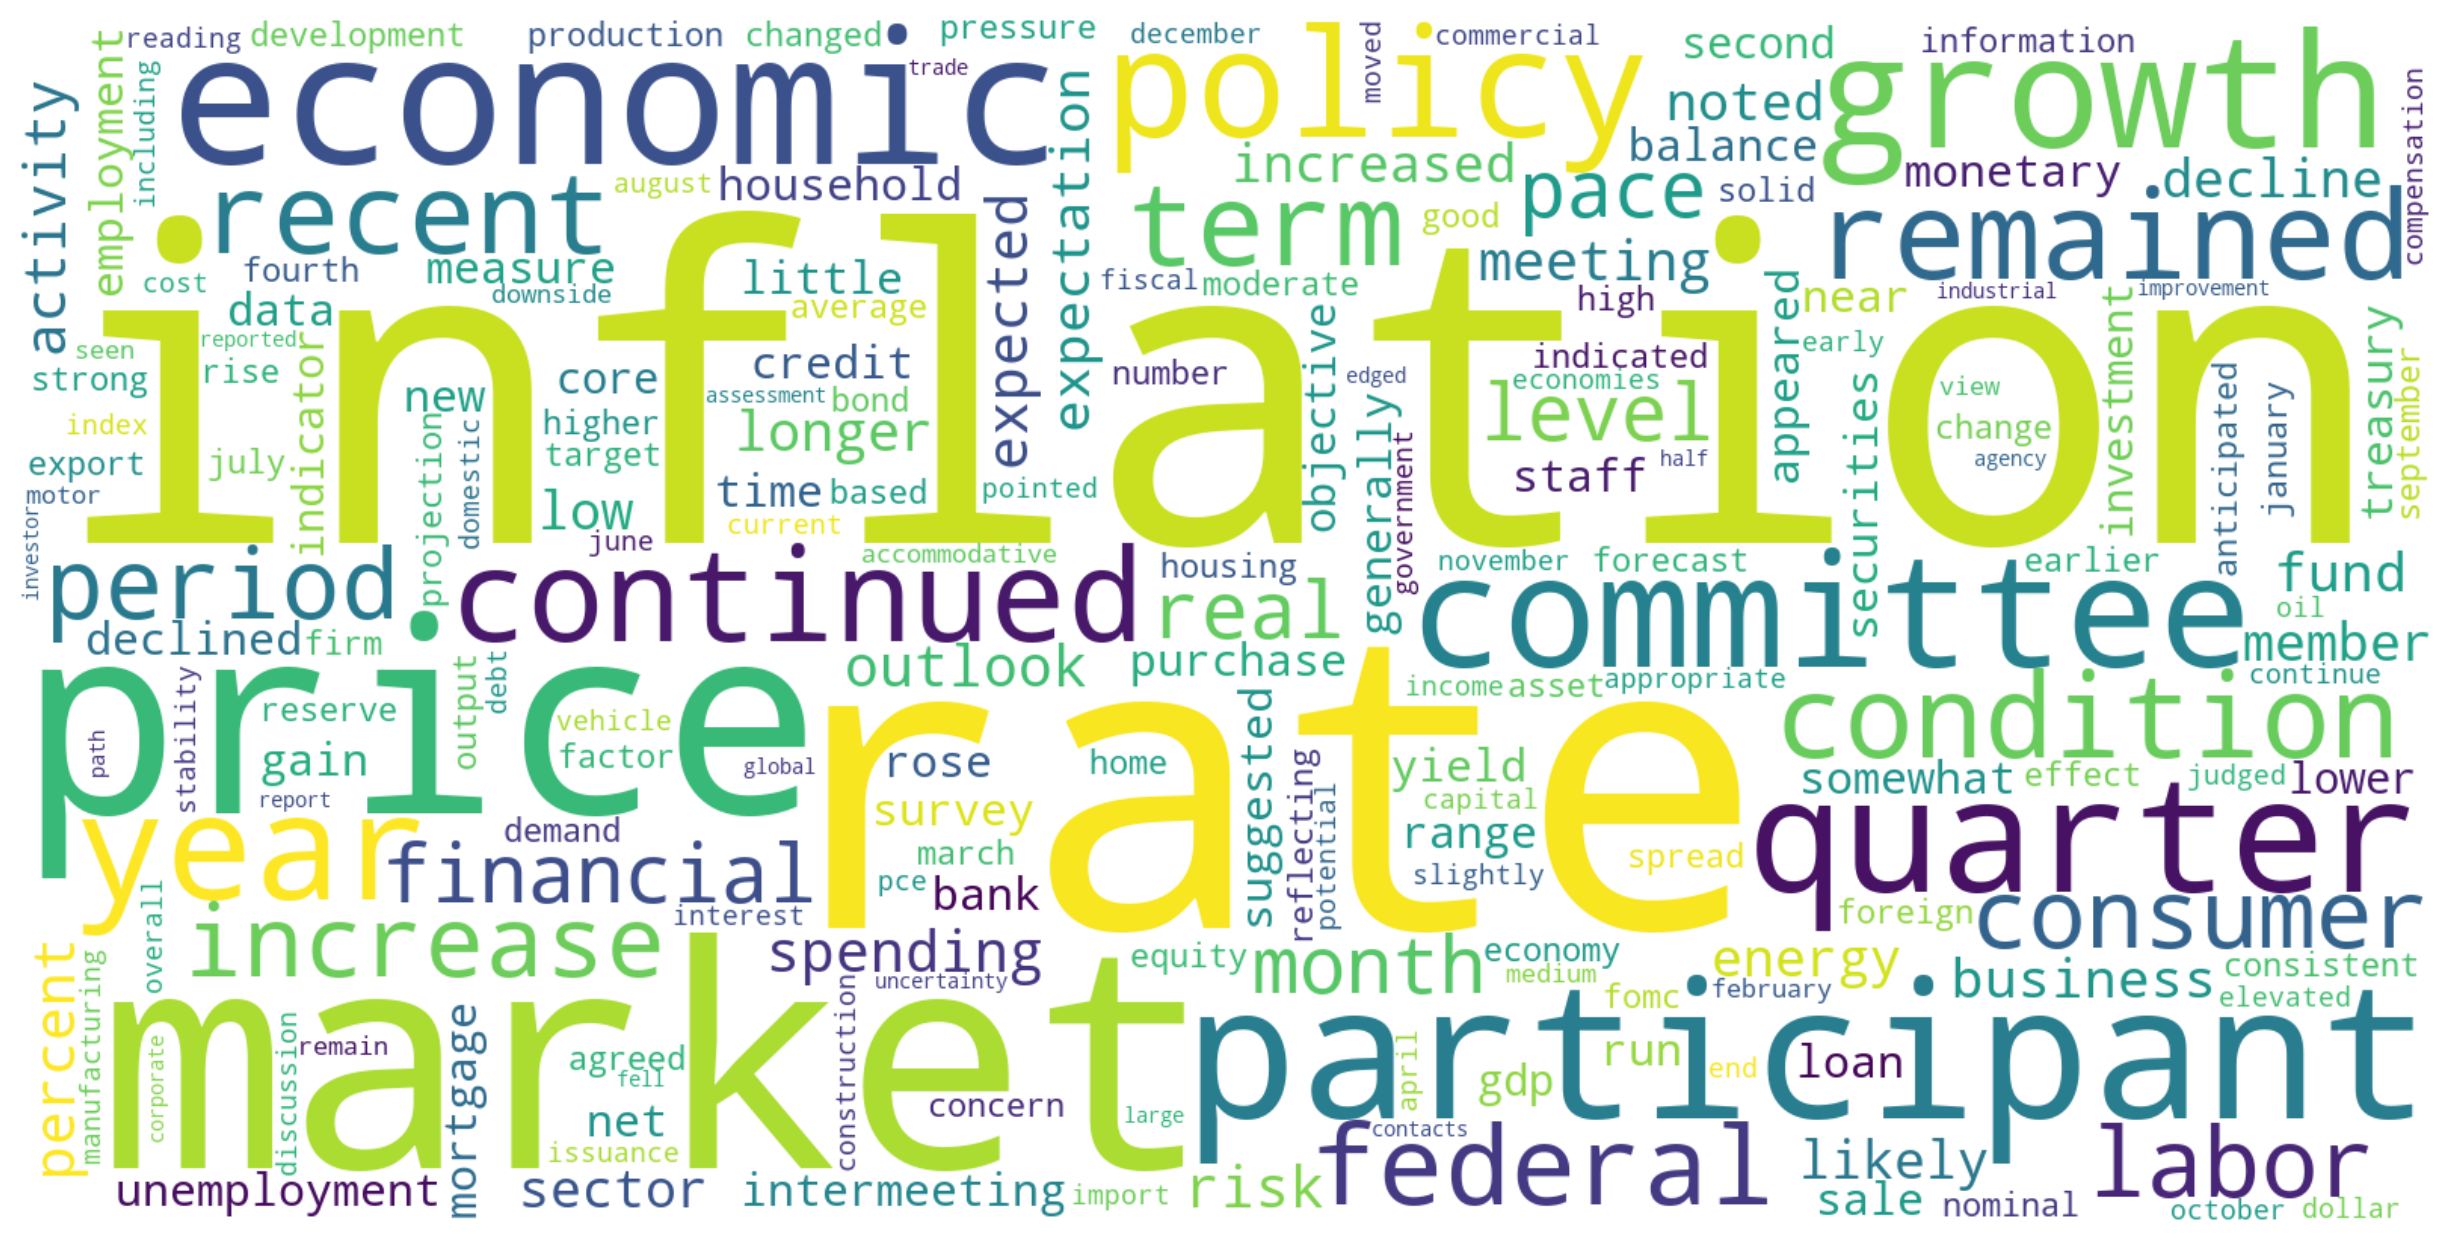

In [11]:
#Most frequent words in corpus
tokenized_text = df_paragraphs['tokenized_text']
all_tokens = [item for sublist in tokenized_text for item in sublist]

wordcloud = WordCloud(collocations=False,
                      background_color='white',
                      mode='RGB',
                      width=1600, height=800).generate((" ").join(all_tokens))

fig = plt.figure(figsize=(16,8),dpi=200)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

The Wordcloud chart above summarizes the top words from the meeting minutes. Not surprisingly, it implies the two mandates Fed has: controling inflation and maintaining growth and employment.

# <a name="topic-m"></a>Topic Modelling 

Now that we have our clean text corpus, we can create a bag of words and pass it into a Latent Dirichlet Allocation model (LDA). This probabilistic model is ideal for our analysis as each paragraph is distributed amongst a set of topics, where topics themselves are defined by words that frequently appear with each other. 

<br>
In our previous example, the phrase "Labor market conditions continued to strengthen in recent months, with the unemployment rate declining further and payroll gains well above a pace consistent with maintaining a stable unemployment rate over time" is one that belongs in the labour market category. Additionally, one might say words like labour, payroll and unemployment are more likely to appear in the same document (or in this case paragraph). 

In [12]:
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

num_topics = 6

## <a name="nmf"></a>NMF

In [111]:
tfidf = TfidfVectorizer(tokenizer = lambda x: x, lowercase = False)
tfidf_fitted = tfidf.fit_transform(list(tokenized_text))

nmf = NMF(n_components = num_topics, random_state=7).fit(tfidf_fitted)
nmf_t = nmf.transform(tfidf_fitted)

print("Cosine similiarity of all paragraphs: %.4f." % cosine_similarity(nmf_t).mean(axis=1).mean())

Cosine similiarity of all paragraphs: 0.4807.


## <a name="lda"></a>LDA

One of the most important inputs in the LDA model is the number of topics (n_components). Given that this is an unsupervised task, there is no best way to choose this input other than trial and error - which in this case results to n_components = 6. 

In [109]:
count_vecs = CountVectorizer(tokenizer = lambda x: x, lowercase = False)
count_vecs_fitted = count_vecs.fit_transform(list(tokenized_text))

lda = LatentDirichletAllocation(n_components = num_topics, random_state=7).fit(count_vecs_fitted)
lda_t = lda.transform(count_vecs_fitted)

print("Cosine similiarity of all paragraphs: %.4f." % cosine_similarity(lda_t).mean(axis=1).mean())

Cosine similiarity of all paragraphs: 0.2977.


The cosine_similiarity of LDA is smaller than NMF and we use LDA as our topic modeling method.

/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Cosine Similiarity of paragraphs in each minutes'}>

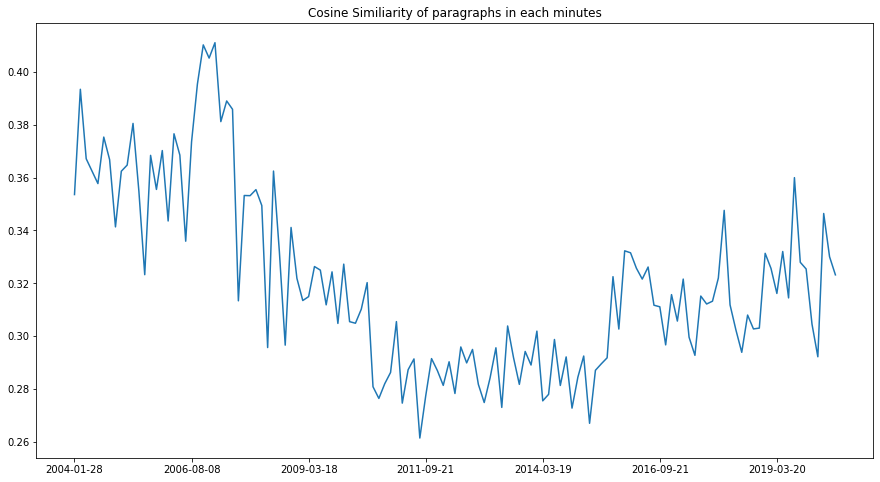

In [106]:
df_paragraphs['topic_weights'] = list(lda_t)

df_lda_vecs_doc = df_paragraphs['topic_weights'].groupby(level=0).apply(np.array)
df_lda_vecs_doc = df_lda_vecs_doc.apply(lambda x: cosine_similarity(np.vstack(x)).mean(axis=1).mean())
df_lda_vecs_doc.index = [str(ts)[:10] for ts in list(df_lda_vecs_doc.index)]
df_lda_vecs_doc.plot(figsize=(15,8), title="Cosine Similiarity of paragraphs in each minutes")

The cosine similarity in each minutes were decresing after 2008.

In [104]:
lda_topic_top_words = summarize_topics(lda,count_vecs.get_feature_names(),10)
lda_topic_top_words

,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,prices,committee,real,period,inflation,quarter
1,remained,federal,quarter,yields,participants,business
2,inflation,policy,consumer,intermeeting,economic,spending
3,consumer,rate,gdp,financial,growth,sector
4,loans,funds,spending,market,labor,production
5,credit,market,growth,treasury,outlook,rate
6,continued,members,second,foreign,market,sales
7,price,conditions,income,markets,recent,continued
8,months,target,forecast,spreads,expected,remained
9,survey,range,pace,equity,prices,months


The output above shows the top 10 words associated to each topic. Some topics are more distinguishable than others, where words such as inflation, price and energy are usually associated to the topic 'Inflation', whilst others are less so.

In [16]:
#Dictionary with topics
topic_dict = {0 : 'Inflation',
              1 : 'Economic Policy',
              2 : 'Growth Outlook', 
              3 : 'Financial Market',
              4 : 'Labor Market', 
              5 : 'Investment'}
topic_dict

{0: 'Inflation',
 1: 'Economic Policy',
 2: 'Investment',
 3: 'Financial Market',
 4: 'Labor Market',
 5: 'Growth Outlook'}

In [17]:
def sum_prop(x):
    x_sum = x.sum(axis=0)
    return (x_sum/x_sum.sum())*100

df_topic_t = df_paragraphs.groupby(level=[0],sort=False)['topic_weights']\
                        .apply(lambda x: sum_prop(x)).apply(pd.Series)\
                        .rename(columns = topic_dict)

df_topic_m = df_topic_t.groupby(level=[0],sort=False).apply(lambda x: sum_prop(x))
topic_perc = df_topic_m.divide(df_topic_m.sum(axis=1), axis=0)

In [18]:
df_topic_m.head()

,Inflation,Economic Policy,Investment,Financial Market,Labor Market,Growth Outlook
2004-01-28,6.424245,19.376254,9.232912,9.430513,23.693131,31.842945
2004-03-16,5.243547,16.277947,9.060297,9.962377,23.616621,35.839211
2004-05-04,7.898664,15.844626,7.644670,9.467879,25.896429,33.247732
2004-06-30,9.201395,15.986722,10.165280,8.130873,23.811100,32.704630
2004-08-10,8.396560,16.213567,12.123760,6.986213,24.062308,32.217591


Text(0.5, 1.0, 'Topic Percentage Over Time')

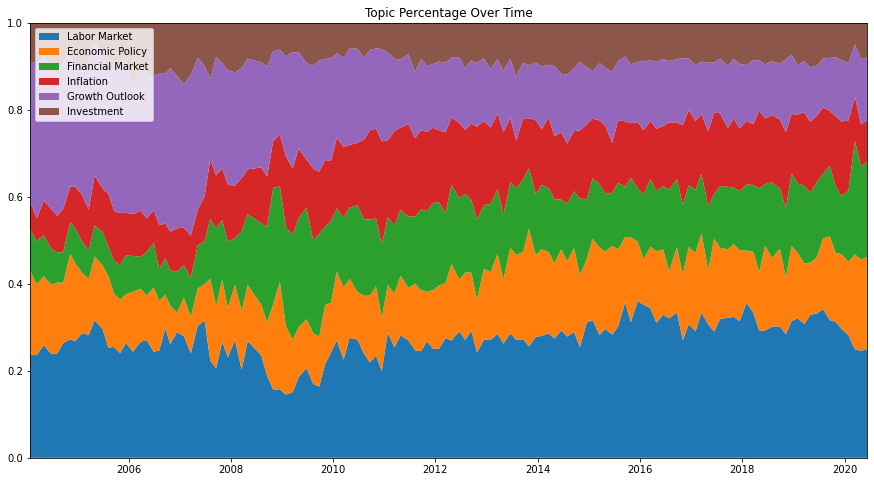

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(df_topic_m.index,  topic_perc["Labor Market"],  topic_perc["Economic Policy"],  topic_perc["Financial Market"], 
              topic_perc["Inflation"],  topic_perc["Growth Outlook"],  topic_perc["Investment"],
              labels=['Labor Market','Economic Policy','Financial Market', 'Inflation', 'Growth Outlook', 'Investment'])
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title('Topic Percentage Over Time')

The shift of topic weights is reasonable. After Global Financial Crisis, the stability of 'Financial Market' gained more attention from the Fed.

To date, the largest topics are 'Economic Policy' and 'Financial Market'. Considering the sharp turn-around on monetary policy and volatile financial market in the first quarter of 2020, this outcome is within expectation.

We also notice the smallest topic currently is 'Economic Growth'. It doesn't necessary mean Fed cares less about this topic. This is probably due to certain overlap between this topic and other main topics. Again, the topics are not mutual exclusion between each other.

# <a name="sent-a"></a> Sentiment Analysis 

Two sets of dictionaries were used in this section: 
1. Havard IV-4 Psychosociological 
2. Loughran and McDonald

The former is less tailored to financial statements, whilst Loughran and McDonald is adapted to include words from 10-K documents (annual financial reports of publicly listed companies).

Given the lack of labelled data, a very simplistic approach is used to calculate sentiment tone: 

\begin{equation*}
Net \ Tone \  = \frac{\#Positive\ words - \#Negative\ words}
                    {\#Positive\ words + \#Negative\ words} \times \frac{1}{\#Total\ words}
\end{equation*}

Where <br>

Net tone > 0 points to a positive tone
<br>
Net tone < 0 points to a negative tone
<br>
Net tone = 0 points to neutral tone


##  <a name="dict"></a> Dictionary Approach 

Text(0.5, 1.0, 'top negative words')

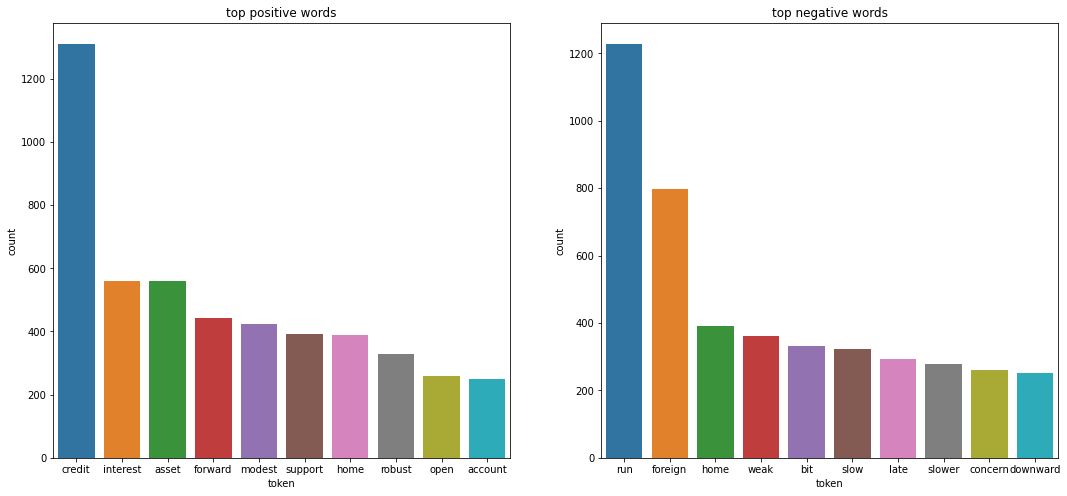

In [20]:
with open(file_path_prefix + 'data/sentiment/sentiment_pos_dict.pickle', 'rb') as handle:
    posDict = pickle.load(handle)
    
with open(file_path_prefix + 'data/sentiment/sentiment_neg_dict.pickle', 'rb') as handle:
    negDict = pickle.load(handle)


corpus_wcount = Counter([item for sublist in tokenized_text for item in sublist])
pos_inter = Counter({w:corpus_wcount[w] for w in posDict.intersection(corpus_wcount)})
neg_inter = Counter({w:corpus_wcount[w] for w in negDict.intersection(corpus_wcount)})

top_pos = pos_inter.most_common(10)
top_neg = neg_inter.most_common(10)

df_top_pos = pd.DataFrame(top_pos, columns=['token', 'count'])
df_top_neg = pd.DataFrame(top_neg, columns=['token', 'count'])

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.barplot(x="token", y="count", data=df_top_pos, ax=ax[0])
ax[0].set_title('top positive words')
sns.barplot(x="token", y="count", data=df_top_neg, label='top negative words', ax=ax[1])
ax[1].set_title('top negative words')

These are the top 10 positive and negative words that appear in the corpus. Certain words clearly express strong sentiment, such as "support", "robust", "weak" or "slow". Others might not sound so intuitively. The reason is that official wording, especially that from regulators, tends to avoid directly influencing the financial markets. People need to read between the lines. This "feeling" may require years of markets experience for a human being to gain. However, NLP may be able to learn it in a fast and systematic way.

In [21]:
print("Number of positive words in corpus: " +str(sum(pos_inter.values())))
print("Number of negative words in corpus: " +str(sum(neg_inter.values())))

Number of positive words in corpus: 11269
Number of negative words in corpus: 9218


## <a name="sent-e"></a> Sentiment Extraction

In [22]:
def RetrieveScore(tokenized_para,positive,negative): 
    pos_sum = 0
    neg_sum = 0
    score = 0
    if len(tokenized_para) <8:
        return 0
    for word in tokenized_para: 
        if word in positive:
            pos_sum +=1
        elif word in negative:
            neg_sum +=1
    try:
        score = ((pos_sum-neg_sum)/(pos_sum+neg_sum))*(1/len(tokenized_para)) #should this be 
    except ZeroDivisionError:
        score = 0
    return score

df_paragraphs['sentiment_score'] = df_paragraphs.apply(lambda x: RetrieveScore(x['tokenized_text'],posDict,negDict),axis=1)


/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

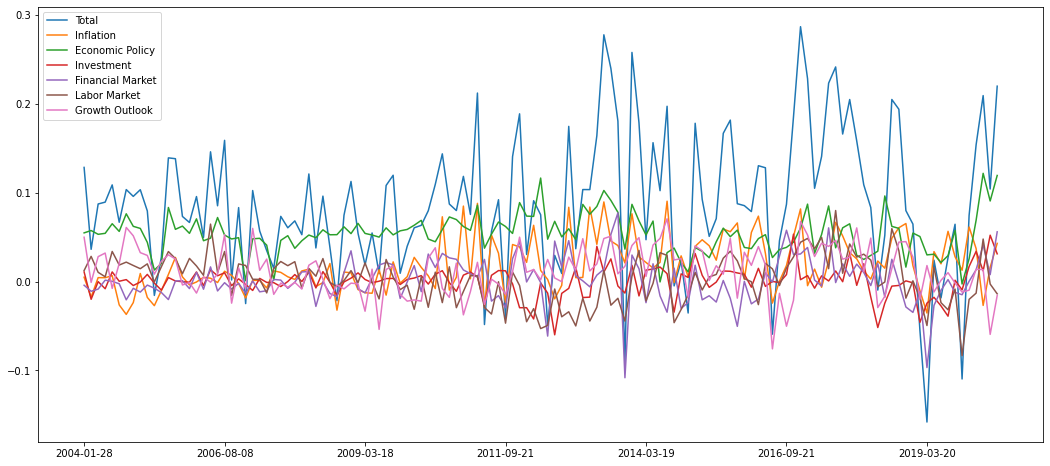

In [23]:
df_sentiment = (df_paragraphs['sentiment_score']*df_paragraphs['topic_weights']).apply(pd.Series).rename(columns = topic_dict)
df_sentiment = pd.concat([df_sentiment.sum(axis=1).rename('Total'),df_sentiment],axis=1)
df_sentiment_m = df_sentiment.groupby(level = [0],sort=False).apply(lambda x: x.sum())
df_sentiment_m.index = [str(ts)[:10] for ts in list(df_sentiment_m.index)]
df_sentiment_m.plot(figsize=(18,8))

The downside of using such a simplistic approach in calculating sentiment is that it can produce some anomalies, in particular for the 'inflation' topic. The word 'inflation' is negative but context is very important when classifying sentiment - in this case the sentence 'Inflation slowed down' should be a positive phrase but is classified as negative. Nevertheless, we can observe a joint dip amongst all topics in 2008, relating to the financial crisis. 

# <a name="model"></a>Modeling

In this section, we build a basedline model and develop more sophisticated models. We split the data into train and test sets. We will compare the accuracy on both for baseline and more sophisticated models.

## <a name="rates"></a>Treasury Rates

US Treasury rates represent the market yields of the debts (bill and bonds) issued by the US Treasury Department. These yields are essentially the "price" of these debts. Yields are usually different for debts maturing at different times. Market practitioners mostly focus on 3-month, 2-year, 5-year and 10-year maturities. With yields from different maturities, we can build a yield curve.

Slope represents the difference between short term (usually 3-month) and long term (usually 10-year) yields (10y yield minus 3m yield). The change of slope indicates the market sentiment of Fed monetary policy, which is based on forecast of future economic conditions. When change of slope is positive, it is called yield curve steepening. Otherwise, it is called flattening.

In [24]:
with open(file_path_prefix + 'data/rates/rates_daily.pickle', 'rb') as handle:
    rates_daily = pickle.load(handle)
    
with open(file_path_prefix + 'data/rates/rates_monthly.pickle', 'rb') as handle:
    rates_monthly = pickle.load(handle)

In [25]:
n_day = 5
df_yc_slope_changes = pd.DataFrame((rates_daily['BC_10YEAR'] - rates_daily['BC_3MONTH']), columns=['slope_change']).pct_change(n_day).shift(-n_day)[:-n_day]
df_yc_slope_changes['steepen'] = df_yc_slope_changes['slope_change'] > 0


In [26]:
combined_df = df_sentiment_m.join(df_yc_slope_changes['slope_change'])
combined_df.corr()

,Total,Inflation,Economic Policy,Investment,Financial Market,Labor Market,Growth Outlook,slope_change
Total,1.000000,0.559449,0.521011,0.464246,0.553919,0.529400,0.513860,0.092028
Inflation,0.559449,1.000000,0.122259,0.198955,0.138029,-0.031722,0.200932,0.193078
Economic Policy,0.521011,0.122259,1.000000,0.155203,0.374250,0.032395,0.070340,0.034685
Investment,0.464246,0.198955,0.155203,1.000000,0.104590,0.265746,0.009593,-0.044488
Financial Market,0.553919,0.138029,0.374250,0.104590,1.000000,0.158347,-0.025186,0.128151
Labor Market,0.529400,-0.031722,0.032395,0.265746,0.158347,1.000000,0.230355,-0.100809
Growth Outlook,0.513860,0.200932,0.070340,0.009593,-0.025186,0.230355,1.000000,0.033726
slope_change,0.092028,0.193078,0.034685,-0.044488,0.128151,-0.100809,0.033726,1.000000


In [27]:
combined_df = combined_df[~combined_df['slope_change'].isna()]
combined_df

,Total,Inflation,Economic Policy,Investment,Financial Market,Labor Market,Growth Outlook,slope_change
2004-01-28,0.128530,0.004854,0.054799,0.010789,-0.004165,0.012366,0.049887,-0.036585
2004-03-16,0.036279,-0.017494,0.057425,-0.019999,-0.011004,0.028321,-0.000971,0.186131
2004-05-04,0.087339,0.004365,0.053188,-0.000103,-0.008514,0.010366,0.028037,-0.078652
2004-06-30,0.089421,0.004307,0.054279,-0.008127,0.001545,0.005355,0.032062,-0.291793
2004-08-10,0.108835,0.006562,0.065094,0.010818,0.000195,0.033864,-0.007699,0.053191
...,...,...,...,...,...,...,...,...
2019-10-30,-0.109765,0.012689,-0.002798,-0.009409,-0.014874,-0.083475,-0.011898,0.562500
2019-12-11,0.074478,0.061395,0.025652,0.016967,0.000296,-0.020089,-0.009742,0.636364
2020-01-29,0.154079,0.037053,0.069084,0.033951,0.013303,-0.013083,0.013770,1.250000
2020-04-29,0.104211,0.015969,0.090714,0.052179,0.007751,-0.002871,-0.059531,0.132075


In [28]:
print(scipy.stats.pearsonr(combined_df['Total'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Labor Market'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Economic Policy'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Financial Market'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Inflation'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Growth Outlook'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Investment'], combined_df['slope_change']))

(0.09202757641591851, 0.29771157211995886)
(-0.1008092839256167, 0.2537819648641427)
(0.03468549050204456, 0.6952253636179555)
(0.12815127792038658, 0.1462138477678176)
(0.1930784814289326, 0.02774135101209814)
(0.03372626622859434, 0.7032529215241132)
(-0.04448822812410568, 0.6152499287456544)


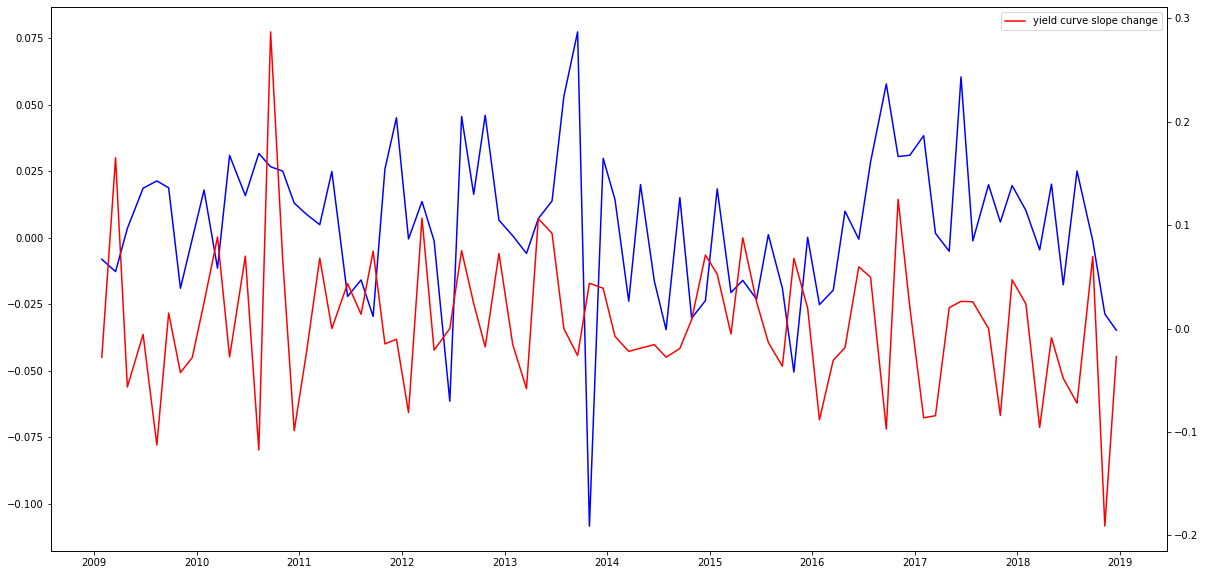

In [29]:
fig, ax_left = plt.subplots(figsize=(20,10))
ax_right = ax_left.twinx()

ax_left.plot(combined_df['Financial Market']["2009":"2018"], color='blue', label='Financial Market')
ax_right.plot(combined_df['slope_change']["2009":"2018"], color='red', label='yield curve slope change')
plt.legend()

## <a name="base"></a>Baseline Model

In [30]:
df_paragraphs_unstack = df_paragraphs.copy()
timestamps = df_paragraphs.index.map(lambda x: str(x[0]))
paragragh_numbers = df_paragraphs.index.map(lambda x: str(x[1]))
df_paragraphs_unstack['paragragh_number'] = paragragh_numbers
df_paragraphs_unstack.index = timestamps
df_paragraphs_unstack = df_paragraphs_unstack.join(df_yc_slope_changes)
df_paragraphs_unstack = df_paragraphs_unstack[~df_paragraphs_unstack['slope_change'].isna()]

In [31]:
x = df_paragraphs_unstack['raw_text']
y = df_paragraphs_unstack['steepen'].astype('bool')

indices = list(range(len(y)))
minutes_train, minutes_val, is_steepen_train, is_steepen_val, indices_train, indices_val = train_test_split(x, y, indices, test_size=0.3, random_state=7)
print(len(minutes_val))
print(len(is_steepen_val))

1611
1611


In [32]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=simple_tokenizer)), ('svc', LinearSVC())])
pipe.fit(minutes_train, is_steepen_train)
print("Tfidf Train accuracy: ", pipe.score(minutes_train, is_steepen_train))
print("Tfidf Test accuracy: ", pipe.score(minutes_val, is_steepen_val))

Tfidf Train accuracy:  0.8453141640042598
Tfidf Test accuracy:  0.521415270018622


In [33]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=simple_tokenizer)), ('topics', NMF(n_components=6, random_state=7)), ('svc', LinearSVC())])
pipe.fit(minutes_train, is_steepen_train)
print("NMF Train accuracy: ", pipe.score(minutes_train, is_steepen_train))
print("NMF Test accuracy: ", pipe.score(minutes_val, is_steepen_val))


NMF Train accuracy:  0.5298189563365282
NMF Test accuracy:  0.5301055245189323


In [34]:
#combine both LDA and sentiment scores
lda_sen = np.hstack([np.vstack(df_paragraphs_unstack['topic_weights']), np.vstack(df_paragraphs_unstack['sentiment_score'])])

baseline_train_vecs = lda_sen[indices_train]
baseline_val_vecs = lda_sen[indices_val]

svc = LinearSVC()
svc.fit(baseline_train_vecs, is_steepen_train)
train_preds = svc.predict(baseline_train_vecs)
test_preds = svc.predict(baseline_val_vecs)

print('Baseline Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('Baseline Model Test accuracy:', accuracy_score(is_steepen_val, test_preds))

Baseline Model Train accuracy: 0.5300851970181044
Baseline Model Test accuracy: 0.5313469894475481


The baseline model we choose include basic word count and topic models: Tfidf , NMF and LDA. Their test accuracy is similar, around 58%. Notably, Tfidf generates very high train accuracy, but not the case for test data set. This is due to overfitting. While NMF and LDA, topic models, have better generalization, which avoids overfitting.

## <a name="glove"></a>GloVe Embeddings 

In [35]:
vocab = set([value for valueList in tokenized_text.values for value in valueList ])
vocab.add('_UNK')
vocab.add('_PAD')

print("Size of vocab:", len(vocab))

glove_dict = dict()
for k in vocab:
    glove_dict[k] = nlp(k).vector

Size of vocab: 5811


In [36]:
glove_vectors = np.empty(shape=(len(df_paragraphs_unstack), 300))
for row, text in enumerate(df_paragraphs_unstack['tokenized_text']):
    glove_vectors_arrays = [glove_dict[word] for word in text]
    glove_vectors[row] = np.mean(glove_vectors_arrays, axis=0)

In [37]:
#combine both GloVe and sentiment scores
glove_sen = np.hstack([glove_vectors, np.vstack(df_paragraphs_unstack['sentiment_score'])])

glove_train_vecs = glove_sen[indices_train]
glove_val_vecs = glove_sen[indices_val]

svc = LinearSVC()
svc.fit(glove_train_vecs, is_steepen_train)
train_preds = svc.predict(glove_train_vecs)
test_preds = svc.predict(glove_val_vecs)

print('GloVe Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('GloVe Model Test accuracy:', accuracy_score(is_steepen_val, test_preds))

GloVe Model Train accuracy: 0.608359957401491
GloVe Model Test accuracy: 0.5183116076970825


## <a name="elmo"></a>Elmo Embeddings 

In [38]:
elmo_vectors = pd.read_pickle(file_path_prefix + 'data/minutes_elmo_vectors.pkl.gz')

if IN_COLAB and elmo_vectors is None:
    from allennlp.commands.elmo import ElmoEmbedder
    elmo = ElmoEmbedder()

In [39]:
if IN_COLAB and elmo_vectors is None:
    elmo_word_vecs = [elmo.embed_sentence(d) for d in df_paragraphs_unstack['raw_text']]
    n_dims = 2 #elmo has three dimensions
    elmo_vecs = np.empty(shape=(len(df_paragraphs_unstack), 1024))
    for row, word_vecs in enumerate(elmo_word_vecs):
        elmo_vecs[row] = np.mean(word_vecs[n_dims,:,:], axis=0)  #take average as the document level embeddings
    pickle.dump(elmo_vecs, gzip.open('minutes_elmo_vectors.pkl.gz', 'wb'))

In [40]:
#elmo_sen = np.hstack([elmo_vectors, np.vstack(df_paragraphs_unstack['sentiment_score'])])
elmo_train_vecs = elmo_vectors[indices_train]
elmo_val_vecs = elmo_vectors[indices_val]

svc = LinearSVC()
svc.fit(elmo_train_vecs, is_steepen_train)
train_preds = svc.predict(elmo_train_vecs)
test_preds = svc.predict(elmo_val_vecs)

print('Elmo Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('Elmo Model Test accuracy:', accuracy_score(is_steepen_val, test_preds))

Elmo Model Train accuracy: 0.6661341853035144
Elmo Model Test accuracy: 0.520794537554314


/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



## <a name="bert"></a>Bert Embeddings 

In [41]:
bert_vectors = pd.read_pickle(file_path_prefix + 'data/minutes_bert_vectors.pkl.gz')

if IN_COLAB and bert_vectors is None:
    from transformers import DistilBertModel, DistilBertTokenizer
    MODEL_NAME = 'distilbert-base-uncased'
    # Load pre-trained model
    distil_model = DistilBertModel.from_pretrained(MODEL_NAME)
    # Load pre-trained model tokenizer (vocabulary)
    distil_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    distil_model.to(device)
    
    st = 0
    batch_size = 5
    batches = list(range(batch_size, len(df_paragraphs_unstack), batch_size))+[len(df_paragraphs_unstack)]
    doc_rep_collector = []
    for b in batches:
        tokens = distil_tokenizer.batch_encode_plus(
            df_paragraphs_unstack['raw_text'][st:b],
            pad_to_max_length=True, 
            return_tensors="pt",
            max_length=512,
            truncation=True)
        st = b
        tokens.to(device)
        outputs = distil_model(**tokens)
        # taking the representation of the 'CLS' token (doc-level embedding)
        o = outputs[0][:,0].cpu().detach().numpy()
        doc_rep_collector.append(o)

    # stack into array
    doc_rep_collector = np.concatenate(doc_rep_collector)
    # to minimize size, can store as 16-bit float
    doc_rep_collector = doc_rep_collector.astype('float16')
    # additionally, will store as gzip (pandas can handle this)
    import gzip
    pickle.dump(doc_rep_collector, gzip.open('minutes_bert_vectors.pkl.gz', 'wb'))

In [42]:
bert_train_vecs = bert_vectors[indices_train]
bert_val_vecs = bert_vectors[indices_val]

bert_svc = LinearSVC()
bert_svc.fit(bert_train_vecs, is_steepen_train)
train_preds = bert_svc.predict(bert_train_vecs)
test_preds = bert_svc.predict(bert_val_vecs)

print('Bert Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('Bert Model Test accuracy:', accuracy_score(is_steepen_val, test_preds))

Bert Model Train accuracy: 0.70580404685836
Bert Model Test accuracy: 0.5493482309124768


/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## <a name="deploy"></a>Deployment

In [43]:
sample = df_paragraphs['raw_text'][-5]
sample

'In their discussion of monetary policy for this meeting, members agreed that the coronavirus outbreak was causing tremendous human and economic hardship across the United States and around the world. The virus and the measures taken to protect public health had induced sharp declines in economic activity and a surge in job losses. Consumer price inflation was being held down by weaker demand and significantly lower oil prices. Financial conditions had improved, in part reflecting policy measures to support the economy and the flow of credit to U.S. households, businesses, and communities. Members agreed that the Federal Reserve was committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum-employment and price-stability goals.'

In [44]:
lda_pipe = Pipeline(steps=[('count_vecs', count_vecs), ('lda', lda)]) 
pickle.dump(lda_pipe, open(file_path_prefix + 'models/lda_pipe.pkl', 'wb'))

In [45]:
from bert_transformer import BertTransformer
from transformers import DistilBertModel, DistilBertTokenizer

MODEL_NAME = 'distilbert-base-uncased'
distil_model = DistilBertModel.from_pretrained(MODEL_NAME)
distil_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

bert_transformer = BertTransformer(distil_tokenizer, distil_model)
classifier = LinearSVC()
bert_svc = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ]
)
bert_svc.fit(x, y)
pickle.dump(bert_svc, open(file_path_prefix + 'models/bert_svc.pkl', 'wb'))

KeyboardInterrupt: 